In [21]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math

In [22]:
from utils import *
from autoencoder import Autoencoder
from sampler import edm_sampler

In [73]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
k = 50
spinup = 1001
spacing = 10
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{date}/{autoencoder_model}/')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.661827802658081
std_data_latent = 5.319980144500732

#ae-3ds-16f-2l-150e-L1-0wd-0.00001l1
#mean_data_latent = -1.2714290618896484
#std_data_latent = 3.313279628753662

# Data Loading

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Autoencoder

In [10]:
import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

# Create an instance of the ConvolutionalAutoencoder class
autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [49]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for batch,_ in train_loader:
            # Get the input data from the batch
            inputs = batch#.cpu()
            latent = autoencoder.encoder(inputs)
            inputs = latent
            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)

        # Calculate the mean and standard deviation
        count = count * 128
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent)

Mean: -1.2714290618896484
Standard Deviation: 3.313279628753662
-0.6357141733169556 2.4275577068328857


# Diffusion

### Architecture

In [12]:
# Minimal U-Net
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1)
        #time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        freqs = torch.arange(half_dim, device=device)

        embeddings = math.log(10000) / (half_dim - 1)
        
        embeddings = torch.exp(freqs * - embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, filters, no_downsamples, image_channels, time_emb_dim):
        super().__init__()

        down_channels = [filters * 2**i for i in range(no_downsamples + 1)]
        up_channels = list(reversed(down_channels))
        out_channels = 1

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        kernel_size = 3 # Change when changing from 65x65
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.ConvTranspose2d(up_channels[-1], out_channels, kernel_size, padding=1)

    def forward(self, x, timestep, class_labels=None):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        
        if class_labels is not None:
            x = torch.cat((x, class_labels), dim=1)
        
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

simple_net = SimpleUnet(filters=16, no_downsamples=2, image_channels=16, time_emb_dim=16)
print("Num params: ", sum(p.numel() for p in simple_net.parameters()))

Num params:  235313


In [34]:
# Preconditioner
class GCPrecond(torch.nn.Module):
    def __init__(self, sigma_data=1, sigma_min=0.02, sigma_max=88, filters=32, no_downsamples=2, img_channels=1, img_resolution = 65, time_emb_dim=16):
        super(GCPrecond, self).__init__()
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        
        self.img_resolution = img_resolution
        self.img_channels = img_channels

        self.model = SimpleUnet(filters=filters, no_downsamples=no_downsamples, image_channels=self.img_channels, time_emb_dim=time_emb_dim)

    def forward(self, x, sigma, class_labels=None):
        dtype = torch.float32
        x = x.to(dtype) # EMA does this
        sigma = sigma.to(dtype).reshape(-1, 1, 1, 1) # EMA does this

        # Change these if we want
        c_skip = self.sigma_data ** 2 / (sigma **2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2+ self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(dtype)
        
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

### Loss function

In [71]:
class GCLoss:
    def __init__(self, sigma_min=0.02, sigma_max=88, rho=7, sigma_data=1):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        self.sigma_data = sigma_data
    
    def __call__(self, model, images, class_labels=None):
        # Sample from F inverse
        rnd_uniform = torch.rand([images.shape[0], 1, 1, 1], device=images.device)
        rho_inv = 1 / self.rho
        sigma_max_rho = self.sigma_max ** rho_inv
        sigma_min_rho = self.sigma_min ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** self.rho

        # Loss weight
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2

        # Generate noisy images
        noise = torch.randn_like(images)
        noisy_images = images + sigma * noise

        # Forward pass
        denoised_images = model(noisy_images, sigma, class_labels)

        # Compute loss
        loss = weight * ((denoised_images - images) ** 2)

        return loss.sum().mul(1/images.shape[0])


### Sampler

In [23]:
def edm_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    xs = [x_next]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        
        xs.append(x_next)

    return x_next, torch.stack(xs[::-1])


### Sampling

torch.Size([1, 2, 8, 8])


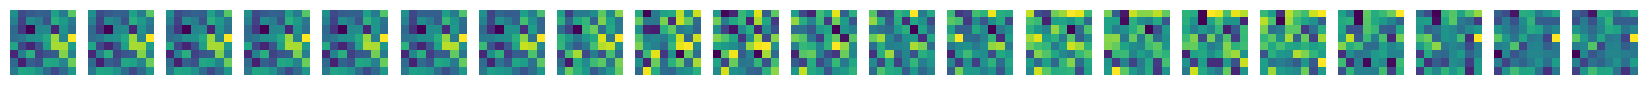

In [62]:
# Redo this part
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    print(image.shape)
    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

#### Forecast

In [31]:
# Redo this part
def sample_and_plot_with_truth(net, class_labels = None, truth = None):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, 1, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    if class_labels is not None:
        images = torch.cat([truth.unsqueeze(0), images], dim=0)
    
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()

In [ ]:
for previous, current in train_loader:
    with torch.no_grad():
        current_latent = autoencoder.encoder(current)
        current_latent = (current_latent - mean_data_latent) / std_data_latent

        previous_latent = autoencoder.encoder(previous)
        previous_latent = (previous_latent - mean_data_latent) / std_data_latent
    
    current_latent = current_latent[0].unsqueeze(0)
    previous_latent = previous_latent[0].unsqueeze(0)
    break
sample_and_plot_with_truth(model, class_labels = previous_latent, truth = current_latent)

In [40]:
# Redo this part
def sample_and_upsample(net, num_images = 1, class_labels=None, img_channels = 1):
    sampler_fn = edm_sampler

    latents = torch.randn([num_images, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, _  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    with torch.no_grad():
        image = image * std_data_latent + mean_data_latent
        image = autoencoder.decoder(image.to(torch.float32))

    return image

plt.imshow(sample_and_upsample(model)[0,0].cpu().detach().numpy())
plt.axis('off')
plt.show()

RuntimeError: Given groups=1, weight of size [32, 4, 3, 3], expected input[1, 1, 8, 8] to have 4 channels, but got 1 channels instead

In [38]:
def plot_forecasts(model):
    for previous, current in train_loader:
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            current_latent = (current_latent - mean_data_latent) / std_data_latent

            previous_latent = autoencoder.encoder(previous)
            previous_latent = (previous_latent - mean_data_latent) / std_data_latent
        
        current_latent = current_latent[0].unsqueeze(0)
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = current_latent.size(1)
    num_images = 4
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)
    predicted = sample_and_upsample(model, num_images=num_images, class_labels = class_labels, img_channels=img_channels)

    vmin = min(predicted[0,0].cpu().detach().numpy().min(), current[0,0].cpu().detach().numpy().min(), previous[0,0].cpu().detach().numpy().min())
    vmax = max(predicted[0,0].cpu().detach().numpy().max(), current[0,0].cpu().detach().numpy().max(), previous[0,0].cpu().detach().numpy().max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts(model)

TypeError: sample_and_upsample() got an unexpected keyword argument 'img_channels'

### Training

#### Generating

In [56]:
model = GCPrecond(filters=32, no_downsamples=2, img_channels=2, img_resolution = 8)
model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = GCLoss()

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

In [72]:
import time
loss_fn = GCLoss()
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    for data, _ in train_loader:
        img = data
        optimizer.zero_grad()

        
        with torch.no_grad():
            latent = autoencoder.encoder(img)
            latent = (latent - mean_data_latent) / std_data_latent
        
        
        #latent = img[:,:,:64,:64]
        
        loss = loss_fn(model, latent)

        print(f'Loss: {loss.item()}')      
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data,_ in val_loader:
            img = data

            latent = autoencoder.encoder(img)
            latent = (latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, latent)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    # scheduler.step()
        
    # Sample and plot image
    sample_and_plot(model, img_channels=2)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Loss: 88.9420166015625
Loss: 94.08685302734375
Loss: 95.15669250488281
Loss: 91.38851165771484
Loss: 93.33637237548828
Loss: 91.5606689453125
Loss: 94.42745971679688
Loss: 92.2815170288086
Loss: 92.768310546875
Loss: 95.95890808105469
Loss: 95.2431640625
Loss: 92.72783660888672
Loss: 93.81690979003906
Loss: 94.57896423339844
Loss: 97.57473754882812
Loss: 96.1697998046875
Loss: 96.13735961914062
Loss: 91.89051818847656
Loss: 96.35989379882812
Loss: 96.33052825927734
Loss: 93.11956787109375
Loss: 94.15934753417969
Loss: 92.7939682006836
Loss: 97.3100814819336
Loss: 93.42823791503906
Loss: 93.53899383544922
Loss: 92.64437866210938
Loss: 90.40887451171875
Loss: 95.48895263671875
Loss: 93.77349090576172
Loss: 91.1895751953125
Loss: 96.590576171875
Loss: 93.80625915527344
Loss: 93.63970947265625
Loss: 92.65000915527344
Loss: 91.24959564208984
Loss: 95.36212158203125
Loss: 96.7912826538086
Loss: 92.786865234375
Loss: 94.98936462402344
Loss: 94.27337646484375
Loss: 94.84150695800781
Loss: 93.4

KeyboardInterrupt: 

#### Forecasting

In [74]:
model = GCPrecond(sigma_data=1, filters=32, no_downsamples=2, img_channels=2, img_resolution = 16)
model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = GCLoss()

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

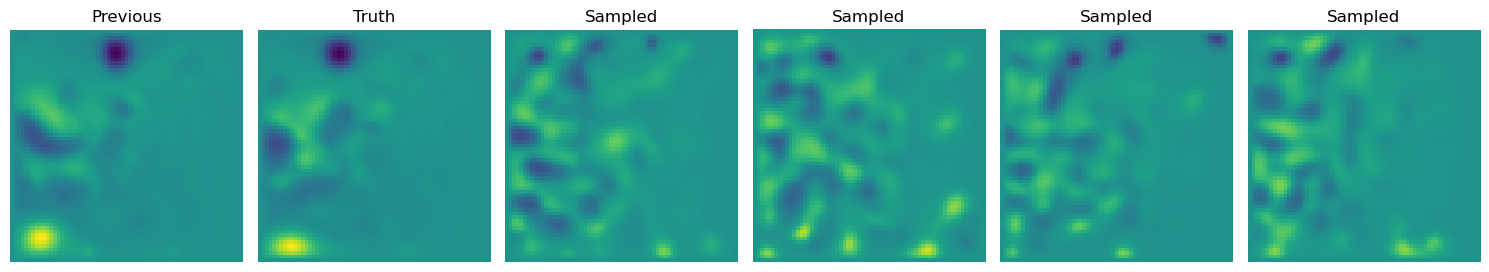

Epoch [1/30], Average Loss: 0.6234, Validation Loss: 0.6280
Training time: 109.97884s, Validation time: 12.33467s, Sample time: 0.52553s


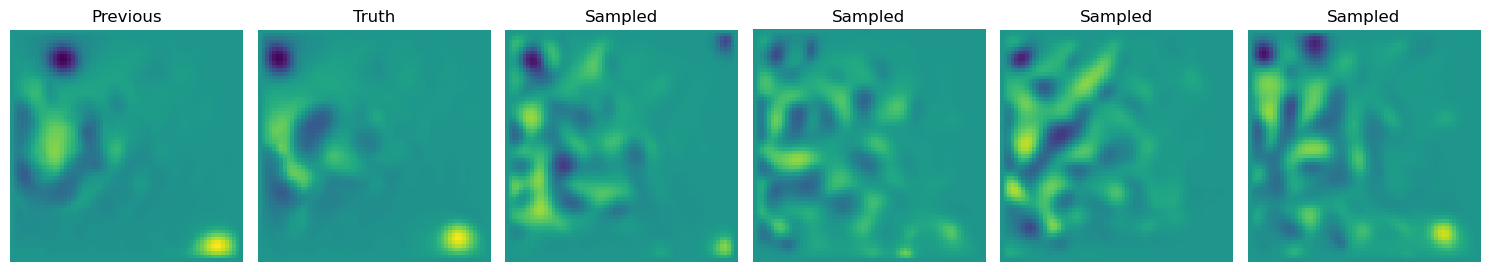

Epoch [2/30], Average Loss: 0.6218, Validation Loss: 0.6282
Training time: 118.40840s, Validation time: 13.15929s, Sample time: 0.39431s


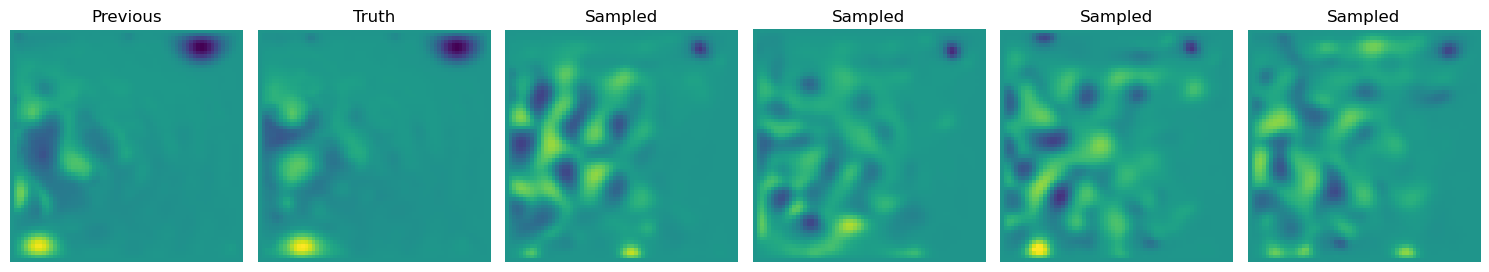

Epoch [3/30], Average Loss: 0.6220, Validation Loss: 0.6267
Training time: 120.95464s, Validation time: 13.60888s, Sample time: 0.57542s


KeyboardInterrupt: 

In [55]:
import time
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    for previous, current in train_loader:        
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            current_latent = (current_latent - mean_data_latent) / std_data_latent

            previous_latent = autoencoder.encoder(previous)
            previous_latent = (previous_latent - mean_data_latent) / std_data_latent
        
        #latent = img[:,:,:64,:64]
        
        loss = loss_fn(model, current_latent, previous_latent)

        #print(f'Loss: {loss.item(      
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in val_loader:
            with torch.no_grad():
                current_latent = autoencoder.encoder(current)
                previous_latent = autoencoder.encoder(previous)
                current_latent = (current_latent - mean_data_latent) / std_data_latent
                previous_latent = (previous_latent - mean_data_latent) / std_data_latent
            
            #latent = img[:,:,:64,:64]
        
            loss = loss_fn(model, current_latent, previous_latent)

            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    # scheduler.step()
        
    # Sample and plot image
    #sample_and_plot(model)
    plot_forecasts(model, )

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

### Misc

In [113]:
# Fix a random image index
for data, _ in train_loader:
    random_image = data[0]
    break

# Get the latent representation of the random image
random_image = random_image.cpu().detach().numpy()

# Calculate the distances between the random image's latent representation and all other latent representations
real_distances = []
fake_distances = []

for data, _ in val_loader:
    data = data[0]
    real_distance = np.linalg.norm(random_image - data.cpu().detach().numpy())
    fake_distance = np.linalg.norm(images[0, 0].detach().numpy() - data.cpu().detach().numpy())

    real_distances.append(real_distance)
    fake_distances.append(fake_distance)


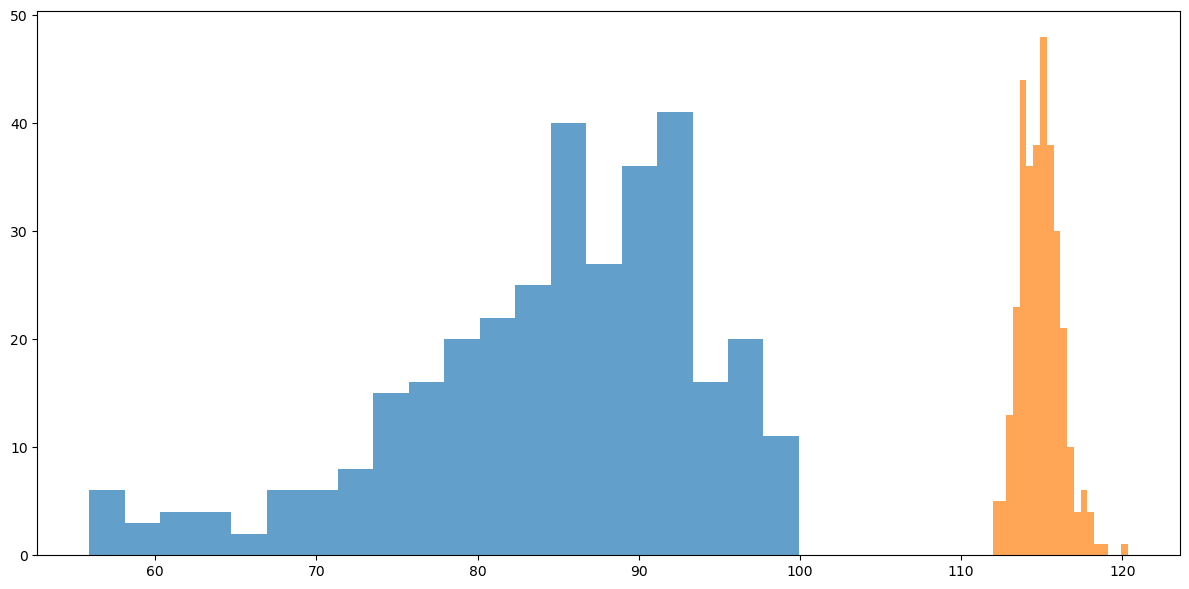

In [114]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

plt.hist(real_distances, bins=20, alpha=0.7, label='Real Images')
plt.hist(fake_distances, bins=20, alpha=0.7, label='Fake Images')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

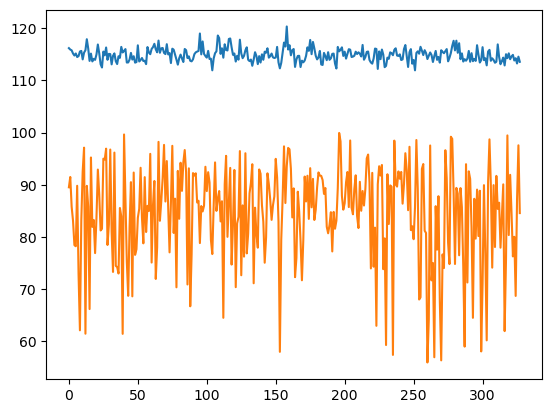

In [115]:
plt.plot(fake_distances)
plt.plot(real_distances)